In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wr = pd.read_csv('./winequality-red.csv')

In [3]:
wr.shape

(1599, 12)

In [35]:
ww = pd.read_csv('./wineQualityWhites.csv')

In [36]:
ww.drop('Unnamed: 0', axis=1, inplace=True)
cols = list(ww.columns)
for i in range(len(cols)):
    snake_i = cols[i].replace('.', '_')
    cols[i] = snake_i
ww.columns = cols

In [38]:
ww.shape

(4898, 12)

## Exploratory Analysis

In [39]:
ww.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [40]:
ww.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


#### Distributions

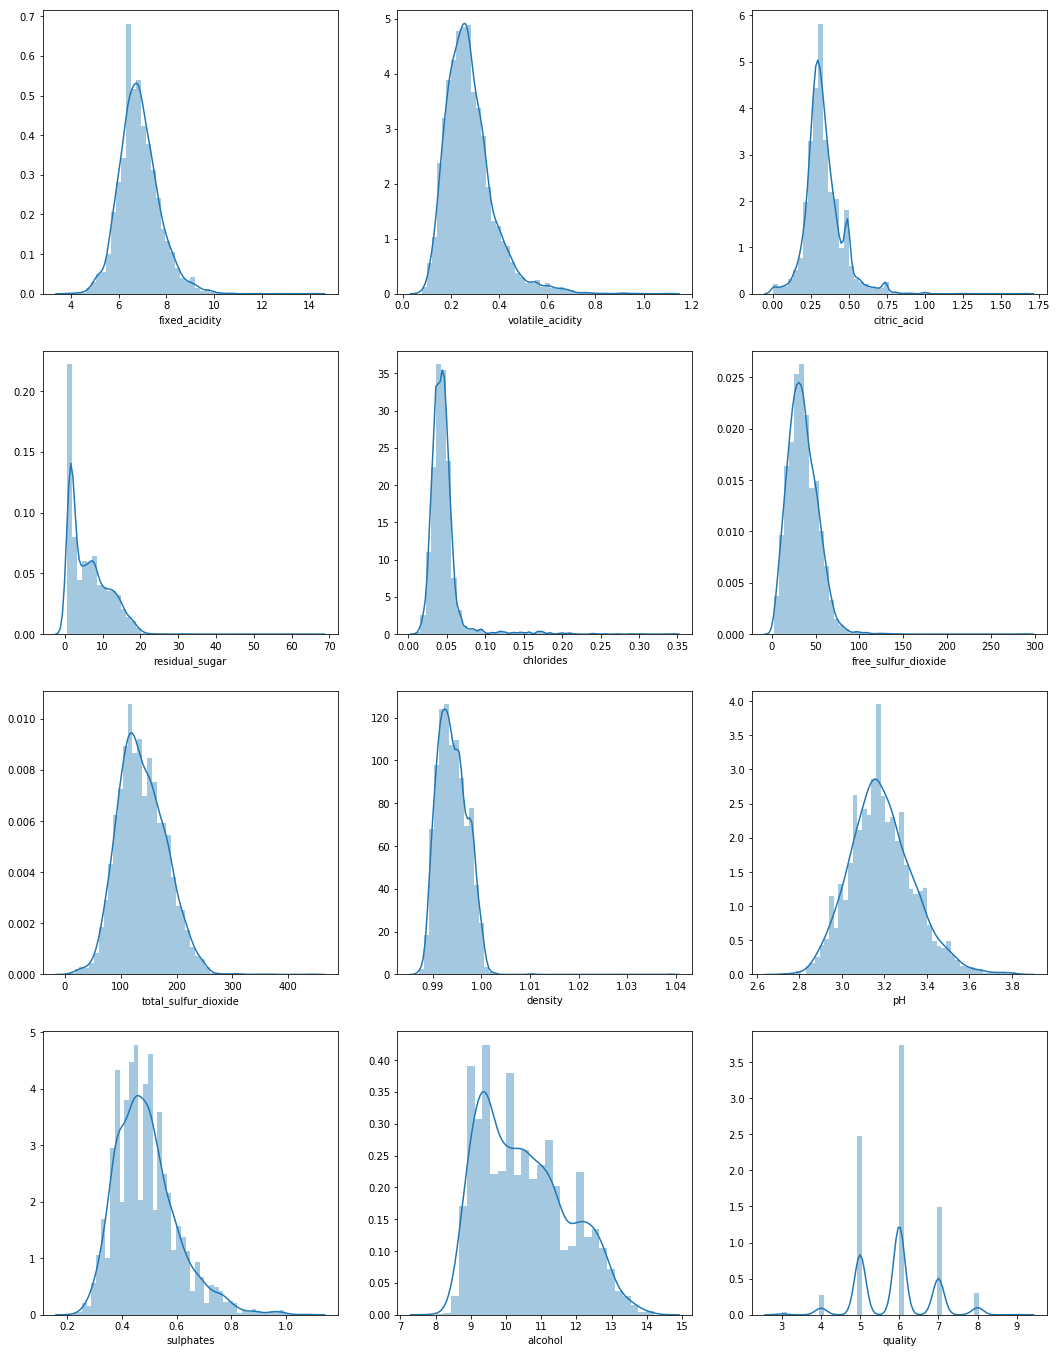

In [41]:
fig, axs = plt.subplots(4,3, figsize = [18,24])
cols = ww.columns
for i in range(12):
    sns.distplot(ww[cols[i]], ax=axs[i//3, i%3])

We can see that most of them have gaussian shape except *residual sugar* and *alcool*

#### Correlations

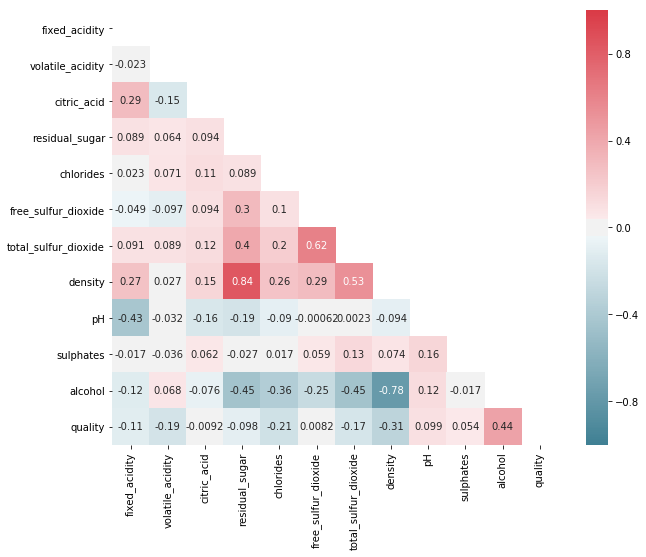

In [42]:
fig, ax = plt.subplots(figsize = [10,8])

corr = ww.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Color Map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,annot=True, ax = ax, vmin=-1, vmax=1, cmap=cmap, mask=mask)
plt.show()

Several good insights here:
- Alcohol seems to be clearly +correlated to quality and density/chlorides/volatile_acidity/total_sulfur seem to be -correlated
- Strong +correlation between free_sulfur and total_sulfur
- Strong +correlation between densiy and residual_sugar
- Strong -correlation between density and alcool
- citric_acid/free_sulfur_dioxide/sulphates look a priori not be of strong correlation

#### Digging into the relation of features to quality

We can plot the relative variation of the median (in %) to caracterize what constitutes a good or a bad wine

In [94]:
meds = ww.median()
quality_meds = ww.groupby('quality').median()
cols = quality_meds.columns
for i in cols:
    quality_meds[i] = (quality_meds[i]-meds[i])/meds[i]

In [131]:
std_quality_meds = pd.DataFrame(np.std(quality_meds, axis = 0))
std_quality_meds.columns = ['var_median']
std_quality_meds.sort_values(by='var_median', ascending=False)

,var_median
residual_sugar,0.294437
free_sulfur_dioxide,0.168303
chlorides,0.124574
total_sulfur_dioxide,0.116671
alcohol,0.096011
volatile_acidity,0.087223
citric_acid,0.066141
fixed_acidity,0.028805
sulphates,0.027524
pH,0.012486


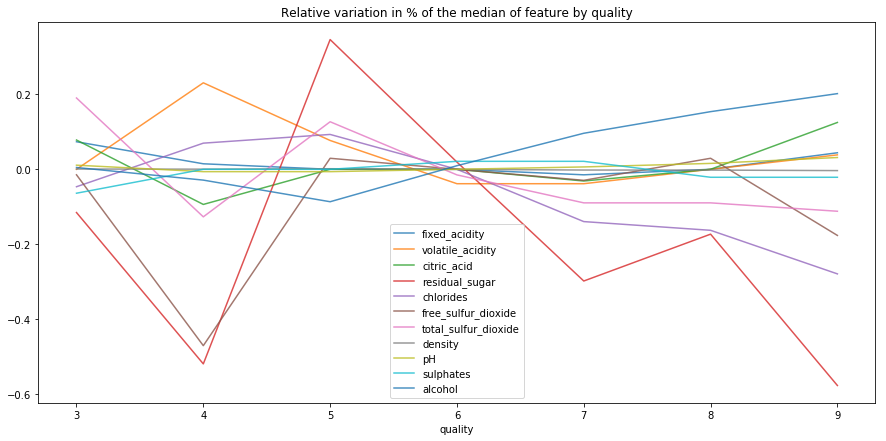

In [95]:
quality_meds.plot(alpha = 0.8, figsize=[15,7], title = 'Relative variation in % of the median of feature by quality')
plt.show()

According to the table and the plot we have some surprising results:
- Residual_sugar looked to be not correlated to quality so we could expect that its median value doesn't really vary depending on the quality. But in fact it is the feature which has the highest relative variance. This might indicate that even if the correlation value is low, this feature might be important. Also we could try to explain this strange behaviour by the change of behaviour if quality is under or over 5 -> to be investigate
- Chlorides, which did not have a high pearson coefficient also looks like having a -correlation with quality according to this graph

For further investigation we will plot the boxplots and pointplots of the feature for each quality

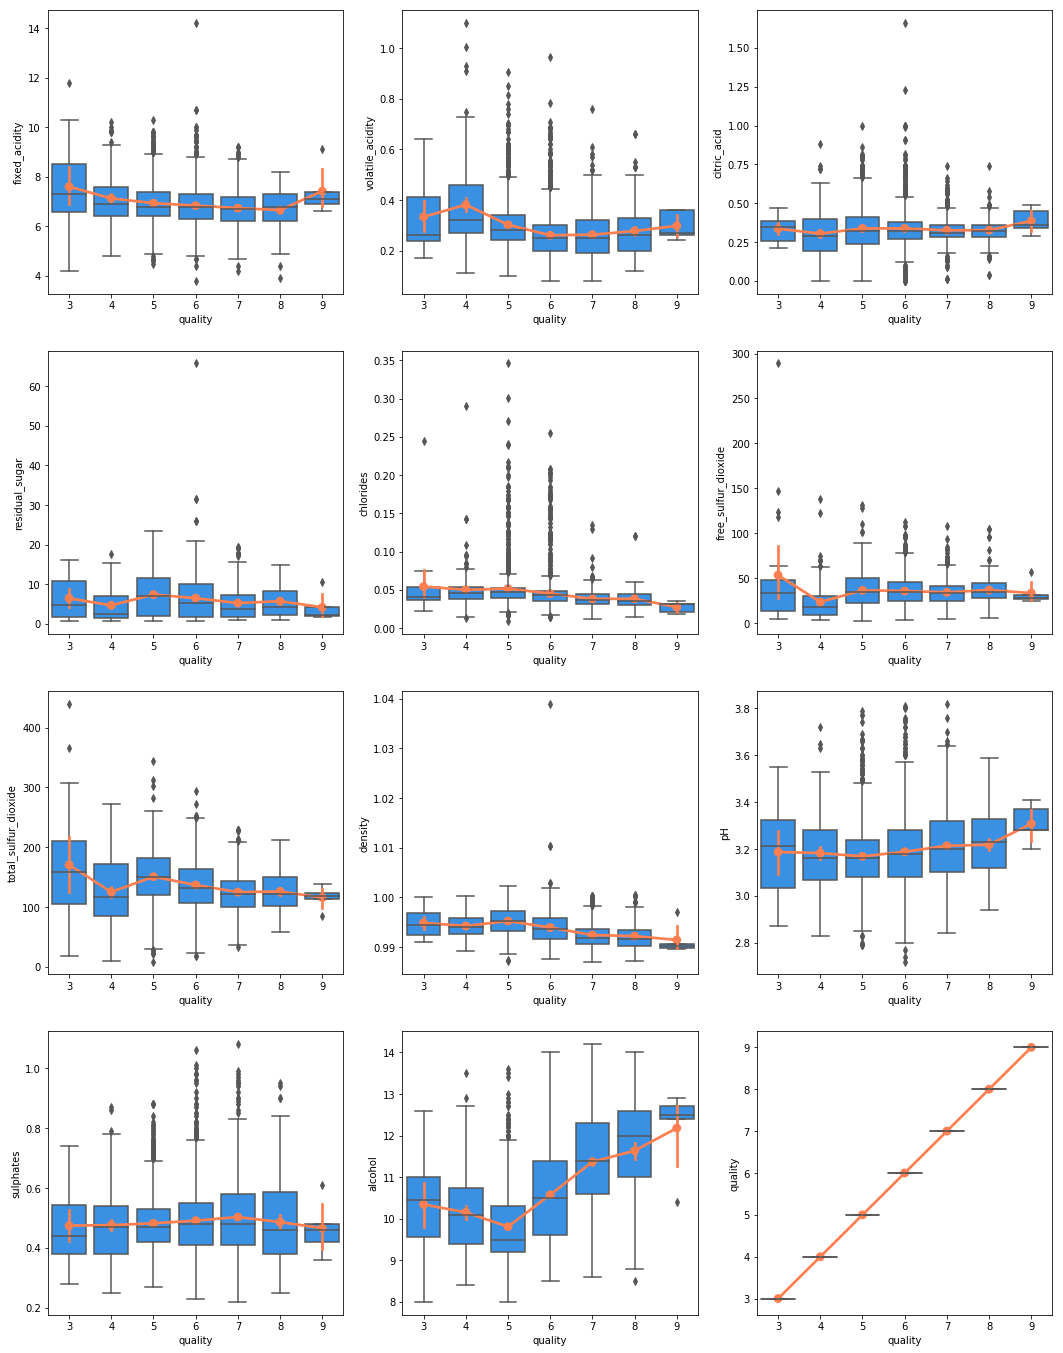

In [188]:
fig, axs = plt.subplots(4,3, figsize = [18,24])
cols = ww.columns
for i in range(12):
    sns.boxplot(data=ww, x='quality', y=cols[i], color='dodgerblue', ax=axs[i//3, i%3])
    sns.pointplot(data=ww, x='quality', y=cols[i], color='coral', ax =axs[i//3, i%3])

Few remarks:
- We can see that for quality = 5, in average there are a lot of values out of the boxplot. This might be because 5 is the average quality and a lot of different combination of features can give an average wine rather than a really good or a really bad wine has specific features.
- Chlorides looks to have a lot of values out of the boxplot

#### Quality into bin 

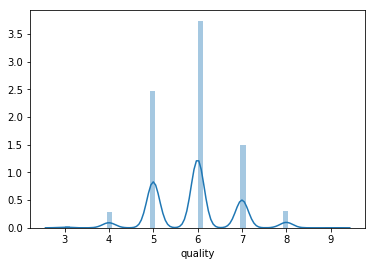

In [166]:
sns.distplot(ww.quality)
plt.show()

Bad : quality <= 4<br>
Average: 5 <= quality <= 7<br>
Good: quality >= 8

In [167]:
ww['quality_bins'] = 'average'
ww.loc[ww.quality >=8, 'quality_bins'] = 'good'
ww.loc[ww.quality <= 4, 'quality_bins'] = 'bad'
scale_order = ['bad', 'average', 'good']
colors = {'bad':'tomato', 'average':'lightgray', 'good':'springgreen'}
ww_bad_good = ww.loc[ww.quality_bins != 'average', :]
scale_order_bg = ['bad','good']
colors_bg = {'bad':'tomato', 'good':'springgreen'}

#### Studying the pairplots to see influence of feature on the bad and good quality

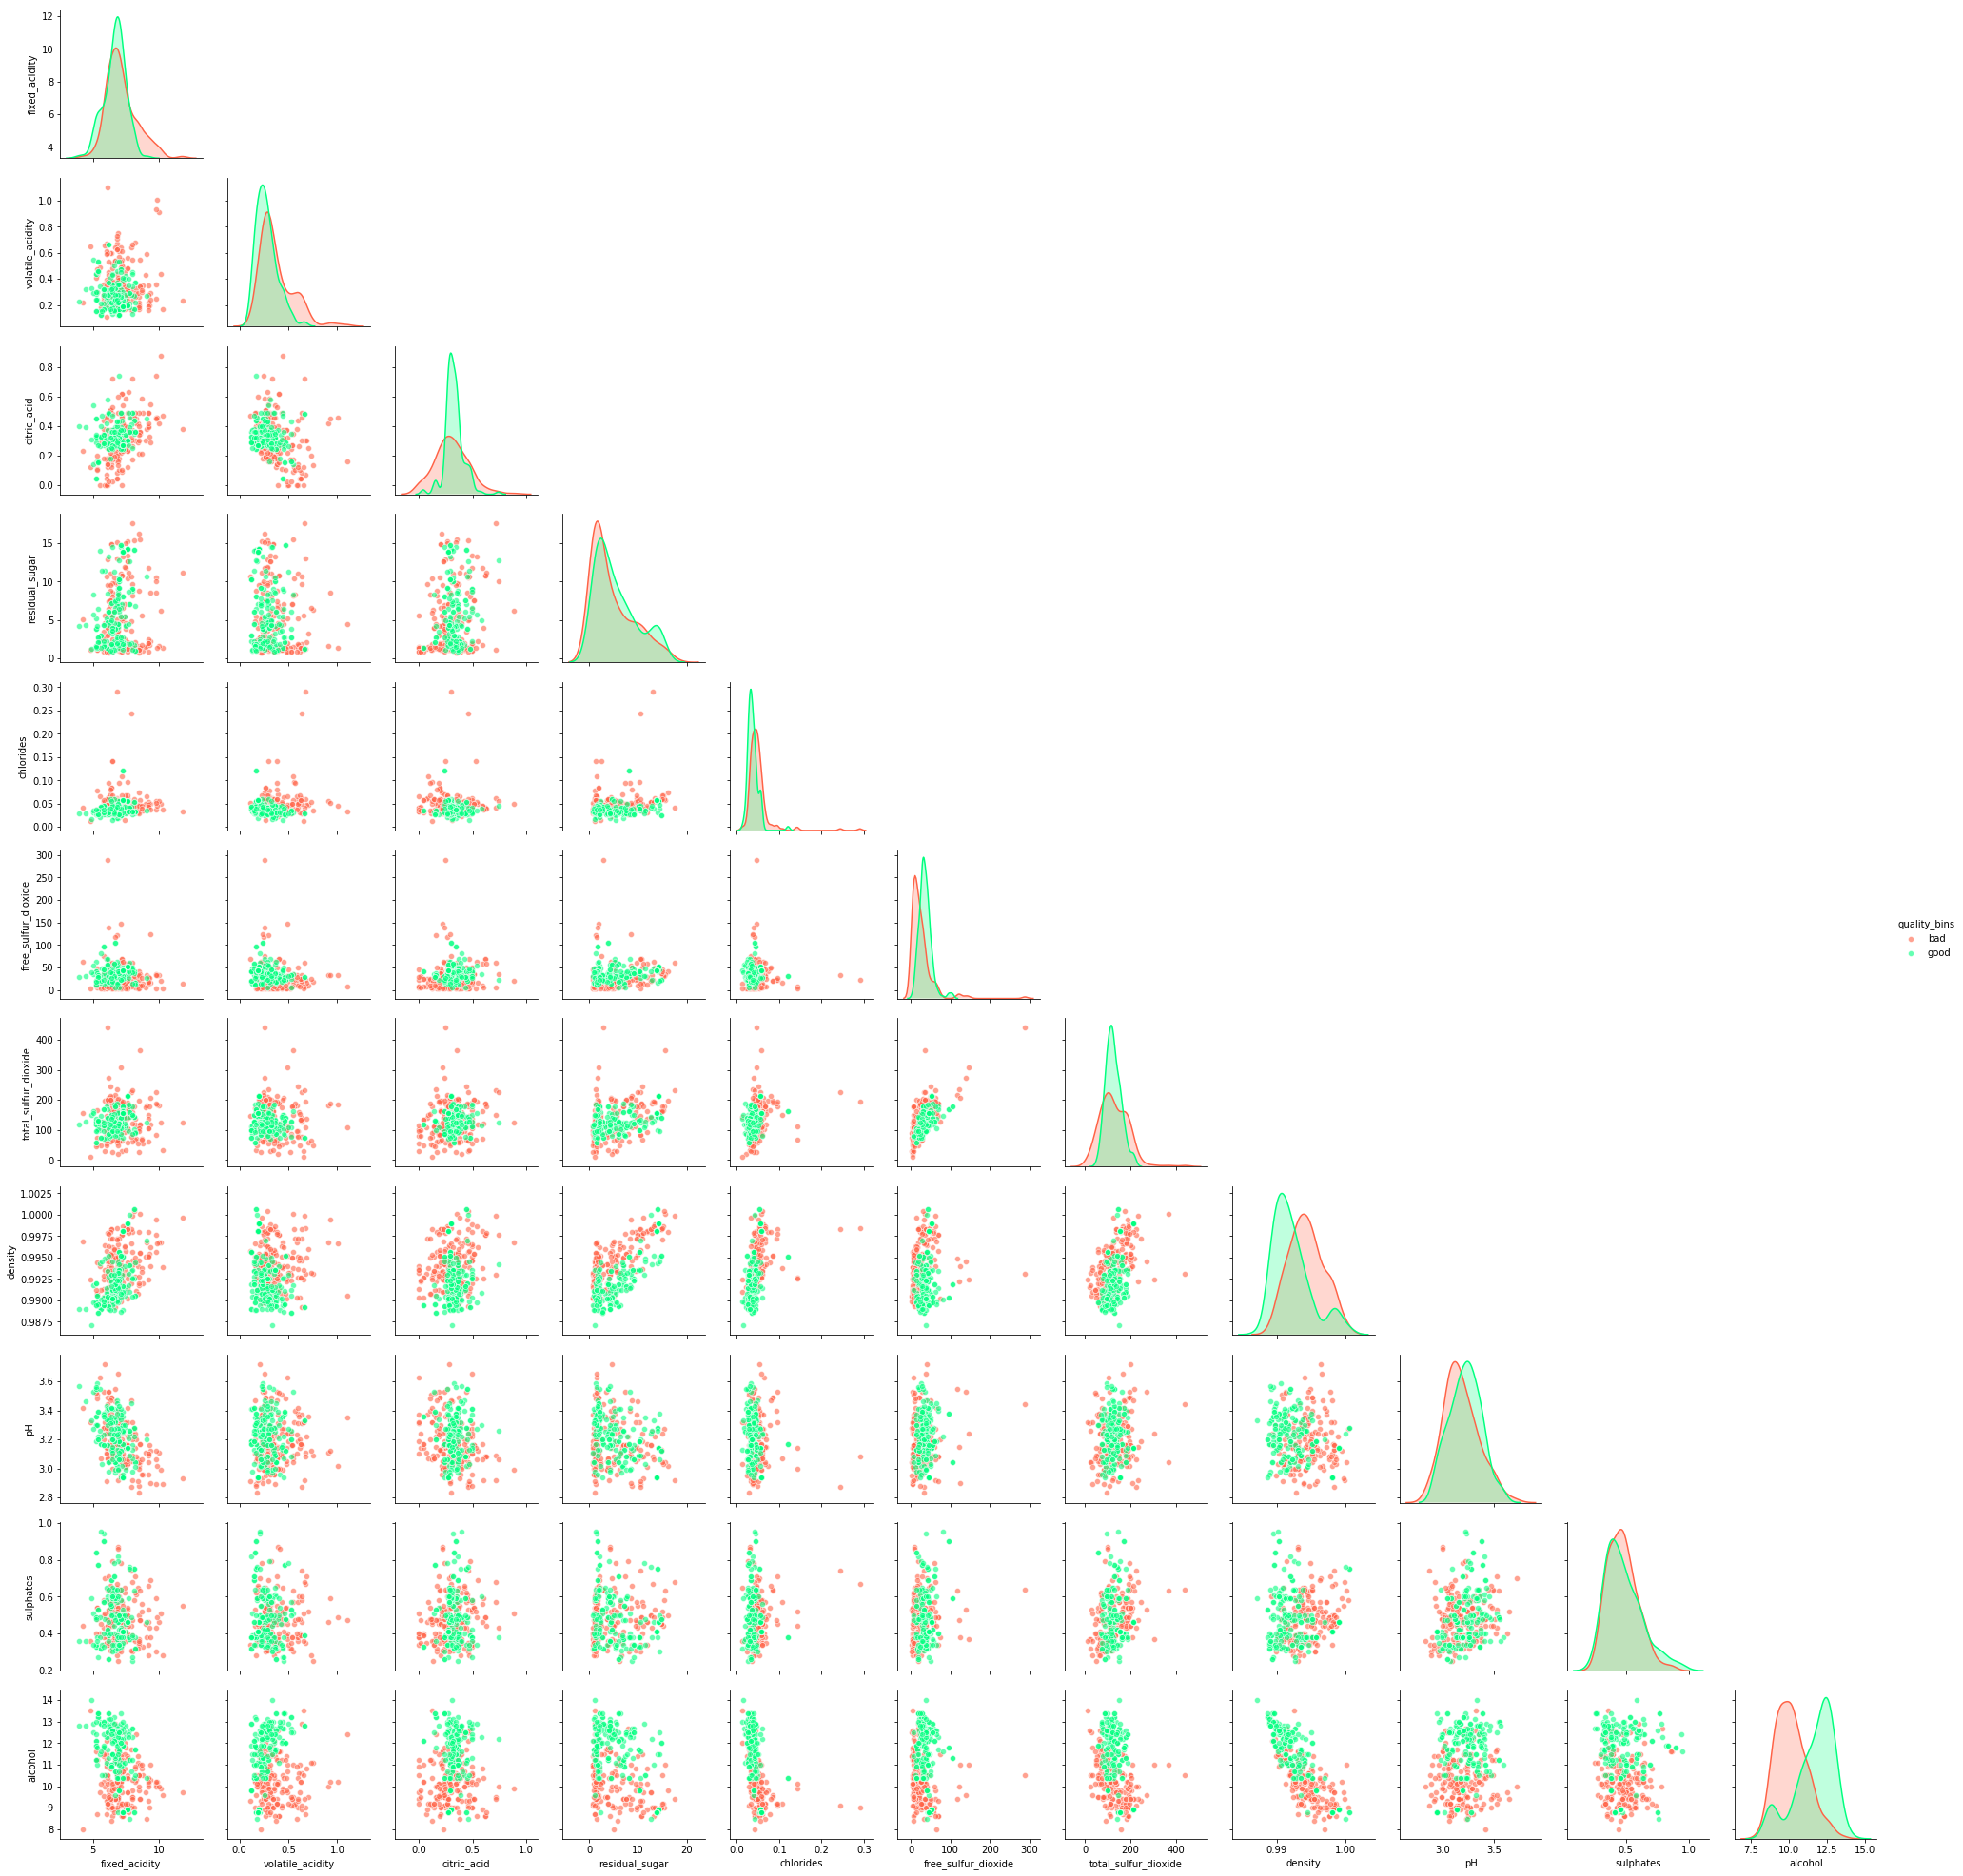

In [170]:
cols = ww_bad_good.columns
cols = cols.drop('quality')
axPP = sns.pairplot(data=ww_bad_good[cols], hue ='quality_bins', hue_order=scale_order_bg, palette=colors_bg, plot_kws={'alpha' : 0.6})
for i, j in zip(*np.triu_indices_from(axPP.axes, 1)):
    axPP.axes[i, j].set_visible(False)

Diagonal plots:
- Generally speaking, the distribution of the good are really narrower than the one of the bad. It looks like being good depends on the features to be on a precise small interval. It is clear on the diagonal plot of 'citric_acid' and 'fixed_acidity' for example
- It is clear here that a higher value of alcohol means a better quality and a lower density also. This will impact the non diag graph. Indeed for alcohol graphs we can see that overall the reds are always low and the green always high.
Non diag graphs:
- Graph (8, 4): *Density / residual_sugar*: Looks like there is a linear relationship between the density and the residual_sugar
- Graph (11, 8): *Alcohol / Density*: Good is in top left corner and bad is in bottom right corner. This is due to the rule that we already noticed on the diagonal plots. But just that graph shows that by only using these features we could already have a decent classification!

#### Summarising the first part of the analysis

Remarks on the features:
- residual_sugar: Not a gaussian shape; -correlation quality; +correlation density; linear relationship density; median varies a lot according to quality
- density: -correlation quality; +correlation residual_sugar; linear relationship residual_sugar -correlation alcohol; Used with alcohol: good way to differentiate good and bad
- chlorides: -correlation quality;
- total_sulfur: -correlation quality; +correlation free_sulfur
- free_sulfur: +correlation total_sulfur; not corr quality
- volatile_acidity: -correlation quality;
- citric_acid: not corr quality
- sulpahtes: not corr quality
- Alcool: not a gaussian shape; +correlation quality; -correlation density; Used with density: good way to differentiate good and bad

Global remarks:
- Harder to caracterize average wines (around 5,6)
- Distribution for the good are narrow: easier to caracterise the goods (>=8)

=> this makes us want to now more about residual_sugar which looks like an interesting feature but with strange behaviour

In [220]:
ww2 = ww
ww2['residual_sugar_rounded'] = round(ww2.residual_sugar)
ww2s = ww2.groupby(['residual_sugar_rounded','quality_bins']).size()
ww2s = ww2s.reset_index()
ww2s.loc[ww2s.residual_sugar_rounded > 15]

,residual_sugar_rounded,quality_bins,0
43,16.0,average,88
44,16.0,bad,2
45,17.0,average,64
46,18.0,average,70
47,18.0,bad,1
48,19.0,average,26
49,20.0,average,16
50,21.0,average,4
51,22.0,average,2
52,23.0,average,1


This tells us that we can put every residual_sugar_rounded over 20 to 20.

In [245]:
ww2.loc[ww2.residual_sugar > 20, 'residual_sugar'] = 20

Before reading the next chart we should keep in mind that the result of the extreme quality are not fully generalisable as there are for example only 5 candidates in quality 9

In [246]:
ww.groupby('quality').size()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64

But let's plot the distribution of residual_sugar for each quality

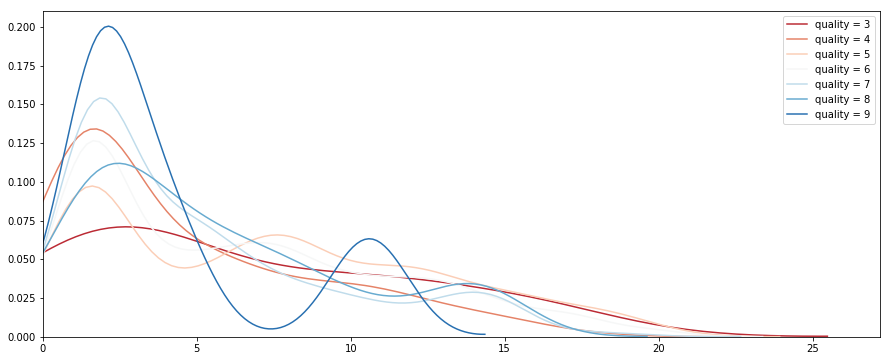

In [244]:
fig, ax = plt.subplots(figsize= [15,6])
palette = sns.color_palette("RdBu", n_colors=7)
for i in range(3,10):
    sns.kdeplot(ww2.loc[ww2.quality == i, 'residual_sugar'], label = 'quality = '+str(i), ax = ax, color = palette[i-3])
ax.set_xlim(left = 0)
plt.show()

The litle spike on high sugar for quality 9 is probably due to one wine only as showed below

In [247]:
ww.loc[ww.quality == 9].groupby(['quality', 'residual_sugar']).size()

quality  residual_sugar
9        1.6               1
         2.0               1
         2.2               1
         4.2               1
         10.6              1
dtype: int64

But overall there seem to be a maximum for good wine sugar around 15.<br>
There also seems to be a minimum which is higer than the minimum of the others qualities as the blue spikes are slightly after the other spikes. <br>
The fact that these difference of spikes looks small but is at the same time where all of the data are and also that we have also big values makes us think that we could use a log value of the residual sugar

In [249]:
ww2['log_rs'] = np.log(ww2.residual_sugar)

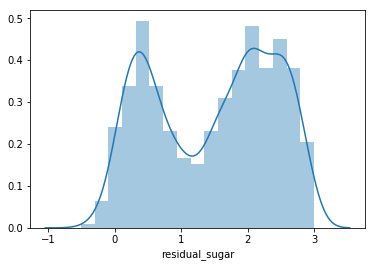

In [251]:
sns.distplot(ww2.log_rs)
plt.show()

This clearly looks better with a nice bi-gaussian

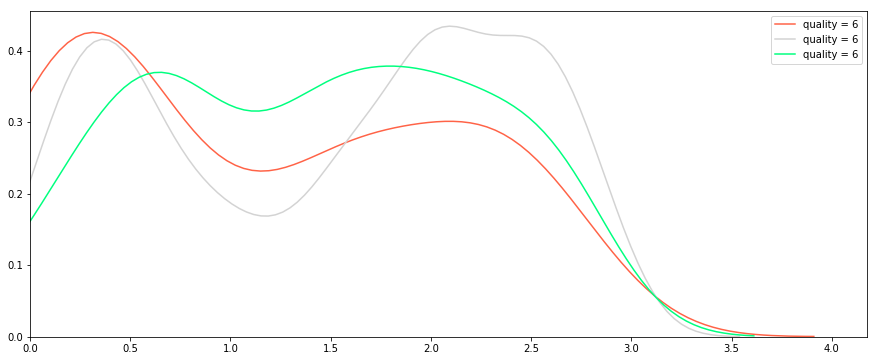

In [300]:
fig, ax = plt.subplots(figsize= [15,6])
sns.kdeplot(ww2.loc[ww2.quality_bins == 'bad', 'log_rs'], label = 'quality = '+str(i), ax = ax, color = 'tomato')
sns.kdeplot(ww2.loc[ww2.quality_bins == 'average', 'log_rs'], label = 'quality = '+str(i), ax = ax, color = 'lightgray')
sns.kdeplot(ww2.loc[ww2.quality_bins == 'good', 'log_rs'], label = 'quality = '+str(i), ax = ax, color = 'springgreen')

ax.set_xlim(left = 0)
plt.show()

In [313]:
ww2.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'quality_bins',
       'residual_sugar_rounded', 'log_rs', 'low_sugar'],
      dtype='object')

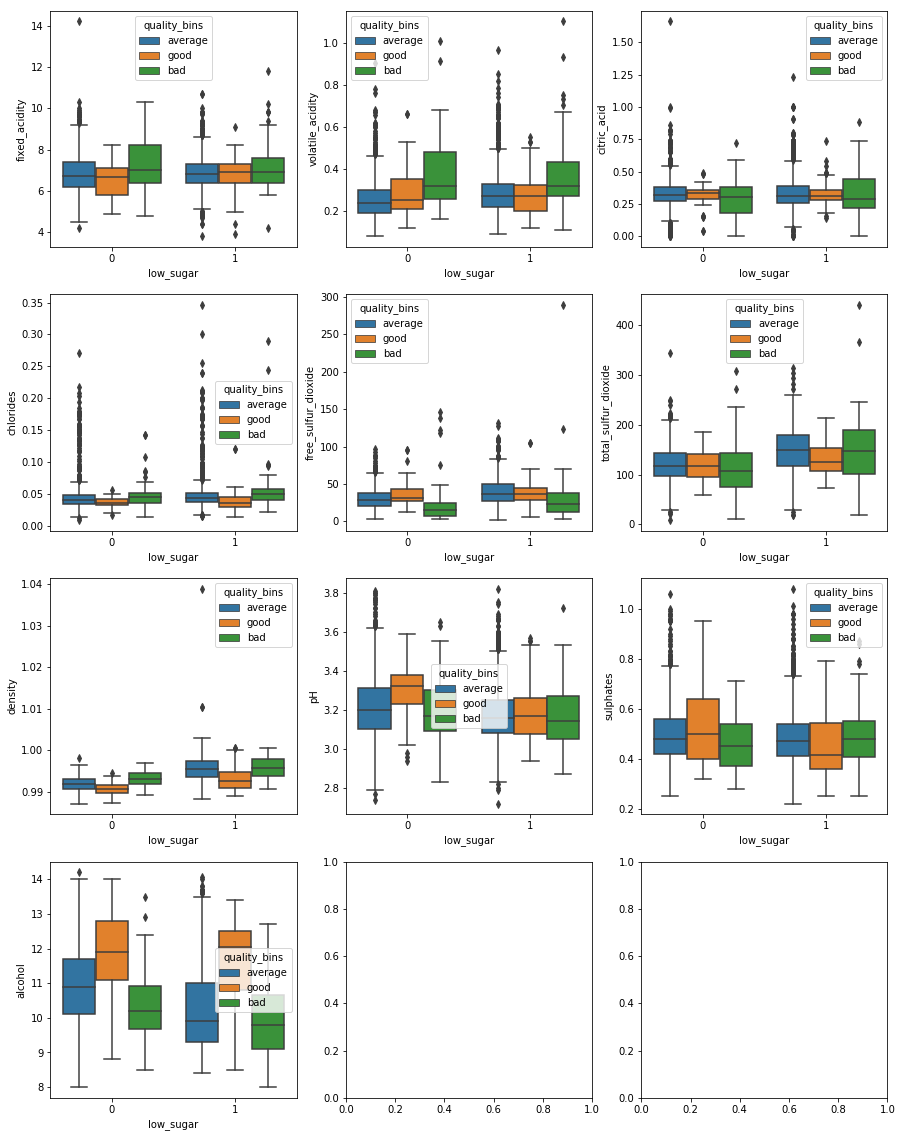

In [334]:
fig, axs = plt.subplots(4,3, figsize=[15,20])
cols = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 
        'density', 'pH', 'sulphates', 'alcohol']
for i in range(10):
    sns.boxplot(data=ww2, x='low_sugar', y = cols[i], ax = axs[i//3, i%3], hue='quality_bins')

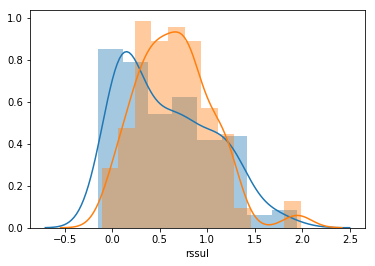

In [323]:
ww3 = ww2
ww3['rssul'] = ww3.log_rs*ww3.sulphates
sns.distplot(ww3.loc[ww3.quality_bins=='bad', 'rssul'])
sns.distplot(ww3.loc[ww3.quality_bins=='good', 'rssul'])


In [324]:
ww3.corr()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,residual_sugar_rounded,log_rs,low_sugar,rssul
fixed_acidity,1.000000,-0.022697,0.289181,0.087760,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663,0.088853,0.069626,0.021062,0.070044
volatile_acidity,-0.022697,1.000000,-0.149472,0.051568,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723,0.063709,0.089696,0.117330,0.093591
citric_acid,0.289181,-0.149472,1.000000,0.092341,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209,0.093656,0.063448,0.018184,0.086549
residual_sugar,0.087760,0.051568,0.092341,1.000000,0.087677,0.308045,0.407668,0.820208,-0.199357,-0.029072,-0.460090,-0.099629,0.988457,0.939655,0.737834,0.871725
chlorides,0.023086,0.070512,0.114364,0.087677,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934,0.087571,0.074236,0.052435,0.081691
free_sulfur_dioxide,-0.049396,-0.097012,0.094077,0.308045,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158,0.298834,0.312729,0.251807,0.312565
total_sulfur_dioxide,0.091070,0.089261,0.121131,0.407668,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737,0.400482,0.418705,0.327471,0.449039
density,0.265331,0.027114,0.149503,0.820208,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123,0.837604,0.751663,0.559427,0.736531
pH,-0.425858,-0.031915,-0.163748,-0.199357,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427,-0.193089,-0.176891,-0.148436,-0.122715
sulphates,-0.017143,-0.035728,0.062331,-0.029072,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678,-0.025480,-0.032143,-0.072560,0.295341


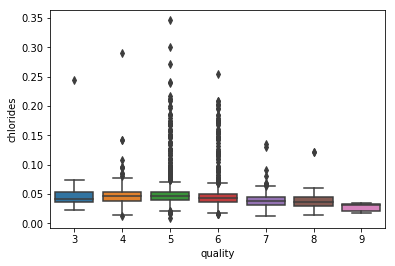

In [335]:
sns.boxplot(x=ww2.quality, y=ww2.chlorides)

In [352]:
ww2['rounded_chlorides'] = round(20*ww2.chlorides)
ww2.groupby(['rounded_chlorides', 'quality']).size()

rounded_chlorides  quality
0.0                3             1
                   4             3
                   5            19
                   6            84
                   7            60
                   8             9
                   9             2
1.0                3            18
                   4           149
                   5          1338
                   6          2046
                   7           816
                   8           164
                   9             3
2.0                4             8
                   5            58
                   6            32
                   7             2
                   8             2
3.0                4             2
                   5            27
                   6            21
                   7             2
4.0                5            10
                   6            14
5.0                3             1
                   5             3
                   6        

In [329]:
(12.2-10)/10.5

0.20952380952380945

In [328]:
ww2.alcohol.mean()

10.514267047774638